In [1]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

In [2]:
# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_tci(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    mean_payoff = mean(discounted_payoffs)
    std_payoff = std(discounted_payoffs)
    error = std_payoff / sqrt(N_PATHS)
    return mean_payoff
end

# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_error(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    mean_payoff = mean(discounted_payoffs)
    std_payoff = std(discounted_payoffs)
    error = std_payoff / sqrt(N_PATHS)
    return mean_payoff, error
end

# TCIワンショット補間関数
function tci_oneshot(func, d, localdims, firstpivot, tol)
    BLAS.set_num_threads(4)
    for _ in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot)
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end
    qtt, ranks, errors = TCI.crossinterpolate2(Float64, func, localdims, [firstpivot],
                                                  tolerance=tol, maxiter=6, verbosity=1,
                                                  loginterval=1, pivotsearch=:rook)
    return qtt, errors
end

tci_oneshot (generic function with 1 method)

In [3]:
using Statistics, Random, Distributions

#―――――――――――――――――――――――――――――――――――――――
# 1) パスごとの割引後ペイオフを返す関数
#―――――――――――――――――――――――――――――――――――――――
function asian_barrier_payoffs(
    j, T, K, B,
    S0s, sigmas, mu, r,
    d_normals, N_STEPS, N_PATHS
) :: Vector{Float64}
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)

    payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]

    for i in 1:N_PATHS
        s = S0
        avg = 0.0
        for n in 1:N_STEPS
            s += tmp1 * s + sigma * s * tmp3 * d_normals[i + (n-1)*N_PATHS]
            avg += (s - avg) / n
            if avg <= B
                # バリア割れならペイオフ0でループ脱出
                avg = 0.0
                break
            end
        end
        payoffs[i] = tmp2 * max(avg - K, 0)
    end
    return payoffs
end

using Statistics

"""
    gamma_asian_barrier(
        j, T, K, B,
        S0s, sigmas, mu, r,
        d_normals, N_STEPS, N_PATHS;
        h = 1e-2
    ) -> (Float64, Float64)

アジアン・バリアオプションのGamma (∂²C/∂S0²) を中心差分近似し、
(推定値, 推定標準誤差) のタプルを返す。

- j = (row_index, col_index) のように `S0s[j[1]]` と `sigmas[j[2]]` を参照
- h: 数値微分に使う小さなステップ (S0を±hしたときの差分を用いる)

内部で `asian_barrier_payoffs` 関数を3回呼び出し、
`S0`, `S0+h`, `S0-h` の3通りの初期株価でペイオフを計算し、二次差分をとる。
"""
function gamma_asian_barrier(
    j, T, K, B,
    S0s, sigmas, mu, r,
    d_normals, N_STEPS, N_PATHS;
    h = 1e-2
) :: Tuple{Float64, Float64}

    # ① S0 を ±h ずらした初期状態を作る
    S0s_up   = copy(S0s)
    S0s_down = copy(S0s)
    # 中間(オリジナル)のS0sはそのまま
    S0s_up[j[1]]   += h
    S0s_down[j[1]] -= h

    # ② 同一の乱数列で3パターンの割引後ペイオフを計算
    pay_mid  = asian_barrier_payoffs(j, T, K, B, S0s,     sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    pay_up   = asian_barrier_payoffs(j, T, K, B, S0s_up,  sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    pay_down = asian_barrier_payoffs(j, T, K, B, S0s_down,sigmas, mu, r, d_normals, N_STEPS, N_PATHS)

    # ③ 各パスごとにガンマ (二次差分)
    #    Gamma_i = (pay_up[i] - 2 * pay_mid[i] + pay_down[i]) / (h^2)
    gammas = (pay_up .- (2 .* pay_mid) .+ pay_down) ./ (h^2)

    # ④ 平均(推定値)と標準誤差を算出
    gamma_mean = mean(gammas)
    gamma_std  = std(gammas)
    gamma_err  = gamma_std / sqrt(N_PATHS)  # 1σの標準誤差

    return gamma_mean, gamma_err
end


"""
    delta_asian_barrier(
        j, T, K, B,
        S0s, sigmas, mu, r,
        d_normals, N_STEPS, N_PATHS;
        h = 1e-2
    ) -> (Float64, Float64)

アジアン・バリアオプションのDelta (∂C/∂S0) を中心差分近似し、
(推定値, 推定標準誤差) のタプルを返す。

- j = (row_index, col_index) のように `S0s[j[1]]` と `sigmas[j[2]]` を参照
- h: 数値微分に使う小さなステップ (S0を±hしたときの差分を用いる)

内部で `asian_barrier_payoffs` 関数を2回呼び出し、
`S0+h`, `S0-h` の2通りの初期株価でペイオフを計算し、差分をとる。
"""
function delta_asian_barrier(
    j, T, K, B,
    S0s, sigmas, mu, r,
    d_normals, N_STEPS, N_PATHS;
    h = 1e-2
) :: Tuple{Float64, Float64}

    # ① S0 を ±h ずらした初期状態を作成
    S0s_up   = copy(S0s)
    S0s_down = copy(S0s)
    S0s_up[j[1]]   += h
    S0s_down[j[1]] -= h

    # ② 同一の乱数列で上方向・下方向の割引後ペイオフを計算
    pay_up   = asian_barrier_payoffs(j, T, K, B, S0s_up,   sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    pay_down = asian_barrier_payoffs(j, T, K, B, S0s_down, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)

    # ③ 各パスごとにデルタ (中心差分)
    #    Delta_i = (pay_up[i] - pay_down[i]) / (2h)
    deltas = (pay_up .- pay_down) ./ (2h)

    # ④ 平均(推定値)と標準誤差を算出
    delta_mean = mean(deltas)
    delta_std  = std(deltas)
    delta_err  = delta_std / sqrt(N_PATHS)  # 1σの標準誤差

    return delta_mean, delta_err
end


delta_asian_barrier

In [4]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################
d = 2
N_STEPS = 365
N_PATHS = 1000       # サンプル数（テスト用なので少なめ）
T = 1.0
K = 110.0
B = 100.0
mu = 0.1
r = 0.05

Random.seed!(1234)
d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 100
n = num_nodes
S0_values = TCIMC.calc_cheby_abscissas(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.calc_cheby_abscissas(0.15, 0.25, num_nodes)

# インデックスを渡す設計のため、例として j = [30, 30] を利用
j = [90, 30]
h_ = 1e-1
gamma_mean, gamma_err = gamma_asian_barrier(
    j, T, K, B,
    S0_values, implied_vol_values, mu, r,
    d_normals, N_STEPS, N_PATHS;
    h = h_
)

println("Gamma ≈ $gamma_mean ± $gamma_err")


Gamma ≈ 0.020717737084994782 ± 0.01082513824619439


In [5]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
abo(j) = asian_barrier_option_tci(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
localdims_v = fill(num_nodes, d)
firstpivot_v = rand(1:num_nodes, d)
phi = TCI.CachedFunction{Float64}(abo, localdims_v)
tol = 1e-2
#tol = 0.00101
#tol = tol_mc

tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(phi, d, localdims_v, firstpivot_v, tol)
end

##########################################################

iteration = 1, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 2, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 3, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0


8.509555

In [6]:
#JLD2.@save "tt_asian_barrier_$tol.jld2" tt_tci

In [7]:
# Grid上での評価結果の比較（TCI vs. Monte Carlo）
##########################################################
# TCIによる評価結果の行列（TT評価はTCIMC._evaluateを利用）
deltamatrix_tci = zeros(n, n)
for i in 1:n, j in 1:n
    deltamatrix_tci[i, j] = TCIMC._evaluate(tt_tci.sitetensors, [i, j])
end

# Monte Carloによる評価結果の行列
price_matrix_mc = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_mc[i, j] = asian_barrier_option_tci([i, j], T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
end

tol_svd = 1e-3
US, Vt = TCI._factorize(price_matrix_mc, :SVD; tolerance = tol_svd, maxbonddim=1000)
U_core = reshape(US, 1, size(US)[1], size(US)[2])
Vt_core = reshape(Vt, size(Vt)[1], size(Vt)[2], 1)

tt_svd_ = [U_core, Vt_core]
@show size(U_core)
@show size(Vt_core)

tt_svd = TCI.TensorTrain(tt_svd_)
#tt_sin_svd.sitetensors

price_matrix_svd = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_svd[i,j] = TCIMC._evaluate(tt_svd.sitetensors, [i, j])
end

size(U_core) = (1, 100, 3)
size(Vt_core) = (3, 100, 1)


In [8]:
M_dct = TCIMC.dct_matrix(n)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, 2))
C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

## sigmaを固定した上で、S0方向に計算ver

In [9]:
# -------------------------------
# どこかで定義済みの辞書 (TCI, SVD, MC) 
# 存在しない場合は空の Dict を用意
# -------------------------------
price_dict_tci = Dict{Tuple{Int,Int}, Float64}()
price_dict_svd = Dict{Tuple{Int,Int}, Float64}()
price_dict_mc  = Dict{Tuple{Int,Int}, Float64}()

# -------------------------------
# 列をひとつ選択
# -------------------------------
col_index = 10  # 例: 10列目（vol = implied_vol_values_equiv[10]）
# col_index = rand(1:num_nodes)  # ランダムに選ぶならこちら
#num_nodes = n
S0_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes))
h_delta    = S0_values_equiv[2]    - S0_values_equiv[1]
Δvol   = implied_vol_values_equiv[2] - implied_vol_values_equiv[1]

# 全インデックスの組を作成して、ランダムに100点抽出

Random.seed!(1234)
all_idx_pairs = [(i, j) for i in 1:num_nodes, j in 1:num_nodes]
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

selected_vol = implied_vol_values_equiv[col_index]
println("選択した列 index: ", col_index, ",  vol = ", selected_vol)

# -------------------------------
# 選択した列について、行を全て計算 or 再利用
# -------------------------------
tci_vals = Float64[]
svd_vals = Float64[]
mc_vals  = Float64[]
xvals    = Float64[]  # x 軸となる S0_values_equiv[i]

for i in 1:num_nodes
    s0_val = S0_values_equiv[i]
    push!(xvals, s0_val)  # x 軸に追加 (今回は S0)

    # ========== TCI ==========
    if haskey(price_dict_tci, (i, col_index))
        price_tci = price_dict_tci[(i, col_index)]
    else
        # まだ辞書に無いなら計算して登録
        weights = [TCIMC.chebyshev_basis_second_derivative(90.0, 120.0, s0_val, n),
                   TCIMC.chebyshev_basis(0.15, 0.25, selected_vol, n)]
        c = 1
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
        price_tci = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
        price_dict_tci[(i, col_index)] = price_tci
    end
    push!(tci_vals, price_tci)

    # ========== SVD ==========
    if haskey(price_dict_svd, (i, col_index))
        price_svd = price_dict_svd[(i, col_index)]
    else
        weights = [TCIMC.chebyshev_basis_second_derivative(90.0, 120.0, s0_val, n),
                   TCIMC.chebyshev_basis(0.15, 0.25, selected_vol, n)]
        c = 1
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
        price_svd = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)
        price_dict_svd[(i, col_index)] = price_svd
    end
    push!(svd_vals, price_svd)

    # ========== MC ==========
    if haskey(price_dict_mc, (i, col_index))
        price_mc = price_dict_mc[(i, col_index)]
    else
        # Monte Carlo で計算 (asian_barrier_option_tciはユーザー定義と想定)
        price_mc, gamma_err = gamma_asian_barrier(
        [i, col_index], T, K, B,
        S0_values, implied_vol_values, mu, r,
        d_normals, N_STEPS, N_PATHS;
        h = h_delta
    )
        price_dict_mc[(i, col_index)] = price_mc
    end
    push!(mc_vals, price_mc)
end


選択した列 index: 10,  vol = 0.1590909090909091


In [10]:
@JLD2.save "svd_vals_1d_S0_asian_barrier.jld2" svd_vals
@JLD2.save "tci_vals_1d_S0_asian_barrier.jld2" tci_vals
@JLD2.save "mc_vals_1d_S0_asian_barrier.jld2" mc_vals
@JLD2.save "xvals_1d_S0_asian_barrier.jld2" xvals

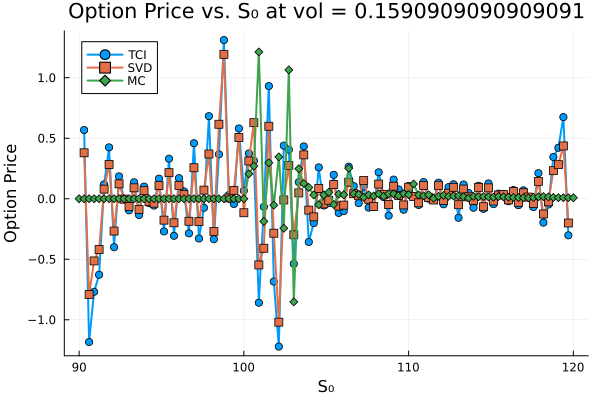

In [11]:
using Plots

p = plot(
    xvals, 
    tci_vals,
    label = "TCI",
    lw = 2,
    marker = :circle,
    xlabel = "S₀",
    ylabel = "Option Price",
    title = "Option Price vs. S₀ at vol = $(selected_vol)",
    legend = :topleft,
    grid = true
)

plot!(p, xvals, svd_vals, label = "SVD", lw = 2, marker = :square) # # #
plot!(p, xvals, mc_vals,  label = "MC",  lw = 2, marker = :diamond) # # #
display(p) #### 
